# Topic 8: Simulating bias for testing mitigation models and fairness

The project aims to simulate bias in data and evaluate how machine learning models trained on biased data behave. Additionally, it will assess different methods to mitigate bias and improve the fairness of the model’s predictions. The main focus is to understand the impact of biased data on a machine learning system and how fairness interventions affect outcomes.


## Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings('ignore')

## Bias In Data


### Bias in Data and its Simulation

In machine learning (ML), bias refers to systematic errors in data that can lead to unfair decisions. Simulating bias involves generating synthetic datasets that replicate these errors, allowing researchers to analyze the impact of bias on model performance and fairness. Through these simulations, researchers can develop methods to mitigate bias, ensuring fairness and accuracy in decision-making processes.

Bias can appear at various stages of the ML pipeline, from data collection to model deployment. If left unchecked, these biases can perpetuate societal inequalities. Simulating bias helps explore its consequences in controlled scenarios, providing insights into how different types of bias affect both fairness and model accuracy.

### Four Fundamental Types of Bias
1. **Historical Bias**: This type of bias occurs when societal inequalities are reflected in the data. For example, differences in income between genders can reflect past injustices, embedding unfair patterns in the data.
2. **Measurement Bias**: Arises when a proxy variable, instead of the true value, is used in decision-making. For example, using IQ tests as a proxy for intelligence may introduce bias if the tests favor certain groups.
3. **Representation Bias**: Happens when a specific subgroup (e.g., based on ethnicity or gender) is underrepresented or misrepresented in the data, leading to biased outcomes.
4. **Omitted Variable Bias**: Occurs when an important variable is omitted, resulting in a model that depends on other variables, potentially correlating with sensitive attributes.

### Mathematical Explanation of Bias

We model the relationships between variables and simulate bias using the following equations:

- Let X represent the feature set, and Y be the target variable. The relationship between these variables can be expressed as: Y = f(X) + ε
  where f(X) is the function describing the relationship between features and the target, and ε represents noise.

Different types of bias affect this system in various ways:

- **Historical Bias**: Occurs when a sensitive attribute A impacts both the features X and the target Y. For example: X = g(X) - βh A where βh is the parameter that determines the strength of historical bias.

- **Measurement Bias**: When proxies \( Px \) and \( Py \) are observed instead of true values X and Y, and these proxies are affected by sensitive attributes:
  \[
  Px = X - βm A + N_Px
  \]
  Here, βm is the measurement bias parameter, and N_Px represents random noise affecting the proxy variable.

- **Representation Bias**: This bias can be modeled by undersampling a subgroup of individuals with a sensitive attribute A = 1. The proportion of the undersampled group can be represented as Pu, the undersampling parameter.

- **Omitted Variable Bias**: This occurs when an important feature is missing. For instance, omitting R from the model and using only X could result in spurious dependencies on the sensitive attribute A.

By adjusting the parameters βh, βm, and Pu, we can simulate various types of bias and examine their effects on fairness and model performance.


## Bias Simulation

In [2]:
def create_synth(var_config, shared_Y=None):
    dim = var_config.get('dim', 1000)  # Default dataset size
    task_type = var_config.get('task_type', 'classification')
    num_classes = var_config.get('num_classes', 2)  # For classification, default to binary

    # Generate primary variable R (unbiased base for Y)
    R_config = var_config.get('R', [{}])[0]
    R_mean = R_config.get('mean', 0)
    R_std = R_config.get('std', 1)
    R_func = R_config.get('func', 'normal')

    if R_func == 'normal':
        R = np.random.normal(R_mean, R_std, dim)
    elif R_func == 'uniform':
        R = np.random.uniform(R_mean, R_std, dim)
    elif R_func == 'binomial':
        R = np.random.binomial(1, 0.5, dim)
    else:
        raise ValueError(f"Unsupported function type for R: {R_func}")

    # Normalize R to fit within defined min/max range
    r_max = R_config.get('max', 1)
    r_min = R_config.get('min', 0)
    R = (R - R.min()) / (R.max() - R.min()) * (r_max - r_min) + r_min

    # Generate auxiliary features Q
    Q_vars = {}
    for var in var_config.get('Q', []):
        Q_func = var.get('func', 'normal')
        if Q_func == 'normal':
            Q_vars[var['name']] = np.random.normal(0, 3, dim)
        elif Q_func == 'uniform':
            Q_vars[var['name']] = np.random.uniform(0, 3, dim)
        elif Q_func == 'binomial':
            Q_vars[var['name']] = np.random.binomial(1, 0.5, dim)
        else:
            raise ValueError(f"Unsupported function type for Q: {Q_func}")

    # Generate sensitive attributes A
    A_vars = {}
    for var in var_config.get('A', []):
        if var['binary']:
            A_vars[var['name']] = np.random.binomial(1, 0.5, dim)
        else:
            A_vars[var['name']] = np.random.normal(0, 3, dim)

    # Apply measurement bias to A variables
    for var in var_config.get('A', []):
        meas_bias = var.get('meas_bias', 0)  # Measurement bias level
        if meas_bias > 0:
            A_var = A_vars[var['name']]
            noise = np.random.uniform(-1, 1, dim)  # Uniform noise for measurement distortion
            A_vars[var['name']] = (1 - meas_bias) * A_var + meas_bias * noise

    # Generate proxy variables P
    P_vars = {}
    for var in var_config.get('P', []):
        surrogate_name = var['surrogate']
        proxy_val = var['proxy_val']
        meas_bias = var.get('meas_bias', 0)

        if surrogate_name in Q_vars:
            surrogate = Q_vars[surrogate_name]
        elif surrogate_name in A_vars:
            surrogate = A_vars[surrogate_name]
        else:
            raise ValueError(f"Surrogate variable {surrogate_name} not found in Q or A variables")

        # Blend surrogate with proxy_val based on measurement bias
        P_vars[var['name']] = (1 - meas_bias) * surrogate + meas_bias * proxy_val

    # Reuse or construct target variable Y
    if shared_Y is None:
        y = R.copy()

        # Add contributions from Q variables
        for var in var_config.get('Q', []):
            Q_var = Q_vars[var['name']]
            Q_importance = var['importance']
            y += Q_importance * Q_var

        # Introduce bias from A variables
        for var in var_config.get('A', []):
            A_var = A_vars[var['name']]
            hist_bias = var['hist_bias']

            # Historical bias negatively influences Y for one class of A
            bias_effect = hist_bias * (A_var == 1) * np.mean(R)  # Reduce Y for class A == 1
            y -= bias_effect

        # Add noise to Y
        sy = var_config.get('sy', 1)  # Standard deviation of noise
        y += np.random.normal(0, sy, dim)

        # Normalize Y to fit within defined range
        y = (y - y.min()) / (y.max() - y.min()) * (r_max - r_min) + r_min

        # Adjust for classification or regression
        if task_type == 'classification':
            thresholds = np.linspace(y.min(), y.max(), num_classes + 1)[1:-1]
            y = np.digitize(y, bins=thresholds)
    else:
        y = shared_Y

    # Assemble the dataset
    data = {'R': R, 'Y': y}
    data.update(Q_vars)
    data.update(A_vars)
    data.update(P_vars)

    dtf = pd.DataFrame(data)

    # Optional undersampling for sensitive attributes
    for var in var_config.get('A', []):
        if var.get('undersampling_rate', 0) > 0:
            A_var = var['name']
            A_indices = dtf.index[dtf[A_var] == 1]
            drop_count = int(var['undersampling_rate'] * len(A_indices))
            drop_indices = np.random.choice(A_indices, drop_count, replace=False)
            dtf.drop(drop_indices, inplace=True)

    # Define feature matrix X and target Y
    X = dtf.drop(columns=['Y'])
    y = dtf['Y']

    # Split train and test sets
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33, random_state=42, 
            stratify=X[list(A_vars.keys())[0]] if task_type == 'classification' else None
        )
    except:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33, random_state=42
        )

    return X_train, X_test, y_train, y_test, y

### Example Use-Case of the Data Generation

In [3]:
# dim = 1000 # Dimension of the dataset

# vars = {

#     'dim': dim,
#     'task_type': 'classification',  # Specify the task type as classification
#     'num_classes': 2,  # Binary classification: Approved (1) or Denied (0)
    
#     # R is the main variable that represents the target variable (normal, uniform, binomial)
#     'R': [
#         {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
#     ],
#     # A is a group of variables that influences the target variable through historical bias.
#     # It can have measurement bias and be used to represent undersamlped instances.
#     'A': [
#         {'name': 'A1', 'hist_bias': 100, 'meas_bias': 10, 'undersampling_rate': 0, 'binary': True},
#         {'name': 'A2', 'hist_bias': 0, 'meas_bias': 50, 'undersampling_rate': 1, 'binary': True},
#         {'name': 'A3', 'hist_bias': 20, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
#     ],
#     # Q is a group of variables that can or not influence the target variable, depending on the importance. (normal, uniform, binomial)
#     'Q': [
#         {'name': 'Q1', 'importance': 1000, 'hist_bias': 10, 'func': 'normal'},
#         {'name': 'Q2', 'importance': 200, 'hist_bias': 10, 'func': 'uniform'},
#     ],
#     # P is a group of variables that are used as proxies for the target variable, value is usually random.
#     'P': [
#         {'name': 'P1', 'proxy_val': np.random.normal(0, 2, dim), 'meas_bias': 1},
#     ],
# }

## Case Study

In this project, 8 different types of datasets were created using the tool above to assess how biased data impacts machine learning models. Each dataset represents a specific type or combination of biases to explore their effects on model performance and fairness.
1. **Baseline**: Baseline data with little to no biased parameters. Will be used as ground truth.

2. **High Historical Bias**: Introduces strong historical biases in the features. This simulates scenarios where past inequalities or systemic biases heavily influence the data distribution.

3. **High Measurement Bias**: Features are affected by significant measurement errors. This represents cases where the data collection process introduces noise or systematic inaccuracies.

4. **Severe Undersampling**: A scenario with extreme undersampling of certain groups or classes, leading to an unbalanced dataset. This tests the impact of representation disparity on model learning.

5. **Combined Bias**: A combination of historical bias, measurement bias, and undersampling. This setting examines how multiple biases interact and compound their effects.

6. **Proxy Influence**: A situation where proxy variables closely mimic the target variable. This tests the model’s reliance on proxies that may perpetuate bias.

7. **High Q Influence**: Increases the importance of a specific group of variables (Q), making them dominant in predicting the target. This tests the model's over-reliance on certain feature groups.

8. **Extreme Bias**: A dataset with extreme levels of all types of bias (historical, measurement, undersampling, and proxy). This serves as a stress test to evaluate the resilience of models under severely biased conditions.

In [28]:
shared_config = {
    "dim": 1000,  # Number of samples
    "task_type": "classification",  # Can be "classification" or "regression"
    "num_classes": 2,  # For classification, number of classes
    'R': [ # Base variable
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
    "Q": [  # Auxiliary features
        {"name": "Q1", "func": "normal", "importance": 0.6},
        {"name": "Q2", "func": "uniform", "importance": 0.7},
        {"name": "Q3", "func": "uniform", "importance": 0.8},
        {"name": "Q4", "func": "normal", "importance": 0.9}
    ],
    "A": [  # Sensitive attributes
        {"name": "A1", "binary": True, "meas_bias": 0, "hist_bias": 0},
        {"name": "A2", "binary": True, "meas_bias": 0, "hist_bias": 0},
        {"name": "A3", "binary": True, "meas_bias": 0, "hist_bias": 0}
    ],
    "P": [  # Proxy features
        {"name": "P1", "surrogate": "Q1", "proxy_val": 1, "meas_bias": 0}
    ],
    "sy": 1,  # Noise standard deviation for Y
}

data_X_train, data_X_test, data_y_train, data_y_test, shared_Y = create_synth(shared_config)

In [29]:
biased_configs = {
    "high_hist_bias": {
        'dim': 1000,
        'task_type': 'classification',
        'num_classes': 2,
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0.5, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.8, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.9, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 0.2, 'hist_bias': 10, 'func': 'normal'},
            {'name': 'Q2', 'importance': 0.5, 'hist_bias': 10, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'surrogate': 'Q2', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 0},
        ],
    },
    "high_meas_bias": {
        'dim': 1000,
        'task_type': 'classification',
        'num_classes': 2,
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0.1, 'meas_bias': 2, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.1, 'meas_bias': -2, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.1, 'meas_bias': 1.5, 'undersampling_rate': 0, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 0.2, 'hist_bias': 0, 'func': 'normal'},
            {'name': 'Q2', 'importance': 0.5, 'hist_bias': 0, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'surrogate': 'Q2', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 0},
        ],
    },
    "severe_undersampling": {
        'dim': 1000,
        'task_type': 'classification',
        'num_classes': 2,
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.5, 'meas_bias': 0, 'undersampling_rate': 0.8, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.7, 'meas_bias': 0, 'undersampling_rate': 0.9, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 0.2, 'hist_bias': 0, 'func': 'normal'},
            {'name': 'Q2', 'importance': 0.5, 'hist_bias': 0, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'surrogate': 'Q2', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 0},
        ],
    },
    "combined_bias": {
        'dim': 1000,
        'task_type': 'classification',
        'num_classes': 2,
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0.3, 'meas_bias': 20, 'undersampling_rate': 0.3, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.6, 'meas_bias': 30, 'undersampling_rate': 0.5, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.8, 'meas_bias': 10, 'undersampling_rate': 0.4, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 0.2, 'hist_bias': 10, 'func': 'normal'},
            {'name': 'Q2', 'importance': 0.2, 'hist_bias': 20, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'surrogate': 'Q2', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 0},
        ],
    },
    "proxy_influence": {
        'dim': 1000,
        'task_type': 'classification',
        'num_classes': 2,
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 0, 'hist_bias': 0, 'func': 'normal'},
            {'name': 'Q2', 'importance': 0, 'hist_bias': 0, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'surrogate': 'Q2', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 0},
        ],
    },
    "high_q_influence": {
        'dim': 1000,
        'task_type': 'classification',
        'num_classes': 2,
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.2, 'meas_bias': 0, 'undersampling_rate': 0, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 1, 'hist_bias': 0, 'func': 'normal'},
            {'name': 'Q2', 'importance': 0.9, 'hist_bias': 0, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'surrogate': 'Q2', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 0},
        ],
    },
    "extreme_bias": {
        'dim': 1000,
        'task_type': 'classification',
        'num_classes': 2,
        'R': [
            {'Name': 'R1', 'mean': 100, 'std': 10, 'function': 'normal'},
        ],
        'A': [
            {'name': 'A1', 'hist_bias': 0.9, 'meas_bias': 50, 'undersampling_rate': 0.8, 'binary': True},
            {'name': 'A2', 'hist_bias': 0.7, 'meas_bias': 60, 'undersampling_rate': 0.7, 'binary': True},
            {'name': 'A3', 'hist_bias': 0.6, 'meas_bias': 40, 'undersampling_rate': 0.2, 'binary': True},
        ],
        'Q': [
            {'name': 'Q1', 'importance': 1, 'hist_bias': 20, 'func': 'normal'},
            {'name': 'Q2', 'importance': 1, 'hist_bias': 30, 'func': 'uniform'},
            {'name': 'Q3', 'importance': 0.2, 'hist_bias': 100, 'func': 'normal'},
            {'name': 'Q4', 'importance': 0.1, 'hist_bias': 0, 'func': 'normal'}
        ],
        'P': [
            {'name': 'P1', 'surrogate': 'Q2', 'proxy_val': np.random.normal(0, 2, 1000), 'meas_bias': 0},
        ],
    }
}

In [31]:
datasets = {}

for setting_name, vars_config in biased_configs.items():
    X_train, X_test, y_train, y_test, y_real = create_synth(vars_config, shared_Y=shared_Y)

    # Create directories if not present
    if not os.path.exists(f'data/{setting_name}'):
        os.makedirs(f'data/{setting_name}')

    # Save or load datasets
    if os.path.exists(f'data/{setting_name}/X_train.csv'):
        X_train = pd.read_csv(f'data/{setting_name}/X_train.csv')
    else:
        X_train.to_csv(f'data/{setting_name}/X_train.csv', index=False)
    
    if os.path.exists(f'data/{setting_name}/X_test.csv'):
        X_test = pd.read_csv(f'data/{setting_name}/X_test.csv')
    else:
        X_test.to_csv(f'data/{setting_name}/X_test.csv', index=False)
    
    if os.path.exists(f'data/{setting_name}/y_train.csv'):
        y_train = pd.read_csv(f'data/{setting_name}/y_train.csv')
    else:
        y_train.to_csv(f'data/{setting_name}/y_train.csv', index=False)
    
    if os.path.exists(f'data/{setting_name}/y_test.csv'):
        y_test = pd.read_csv(f'data/{setting_name}/y_test.csv')
    else:
        y_test.to_csv(f'data/{setting_name}/y_test.csv', index=False)
    
    if os.path.exists(f'data/{setting_name}/y_real.csv'):
        y_real = pd.read_csv(f'data/{setting_name}/y_real.csv')
    else:
        pd.DataFrame({'y_real': y_real}).to_csv(f'data/{setting_name}/y_real.csv', index=False)

    datasets[setting_name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_real': y_real
    }

datasets['baseline'] = {
    'X_train': data_X_train,
    'X_test': data_X_test,
    'y_train': data_y_train,
    'y_test': data_y_test,
    'y_real': shared_Y
}

In [54]:
# for dataset, concatenate all columns and describe
for dataset_name, dataset in datasets.items():
    X_train = dataset['X_train']
    X_test = dataset['X_test']
    y_train = dataset['y_train']
    y_test = dataset['y_test']
    y_real = dataset['y_real']

    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])

    df = pd.concat([X, y, y_real], axis=1)
    # print columns
    print(df.columns)


Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'Y'], dtype='object')
Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'Y'], dtype='object')
Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'Y'], dtype='object')
Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'Y'], dtype='object')
Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'Y'], dtype='object')
Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'Y'], dtype='object')
Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'Y'], dtype='object')
Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'Y'], dtype='object')


### Bias Analysis

In [33]:
bias_analysis_results = {}

In [34]:
for i, setting_name in enumerate(datasets.keys()):
    y_test = datasets[setting_name]['y_test']
    x_test = datasets[setting_name]['X_test']
    y_train = datasets[setting_name]['y_train']
    x_train = datasets[setting_name]['X_train']
    
    # Correlation Heatmap
    df = pd.concat([x_train, y_train], axis=1)
    corr = df.corr()

    clf = RandomForestClassifier(random_state=42)
    clf.fit(x_train, y_train)

    # # Confusion Matrix
    y_pred = clf.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)

    # Feature Importance
    feature_importances = clf.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    feature_importance_df = pd.DataFrame({
        'Feature': x_train.columns[sorted_idx],
        'Importance': feature_importances[sorted_idx]
    })

    # Permutation Importance
    perm_importances = permutation_importance(clf, x_test, y_test, n_repeats=10, random_state=42)
    perm_importance_df = pd.DataFrame({
        'Feature': x_test.columns[sorted_idx],
        'Importance': perm_importances.importances_mean[sorted_idx]
    })

    # Class Imbalance
    class_imbalance = y_train.value_counts(normalize=True)


    bias_analysis_results[setting_name] = {
        'correlation_heatmap': corr,
        'confusion_matrix': cm,
        'feature_importance': feature_importance_df,
        'permutation_importance': perm_importance_df,
        'class_imbalance': class_imbalance
    }

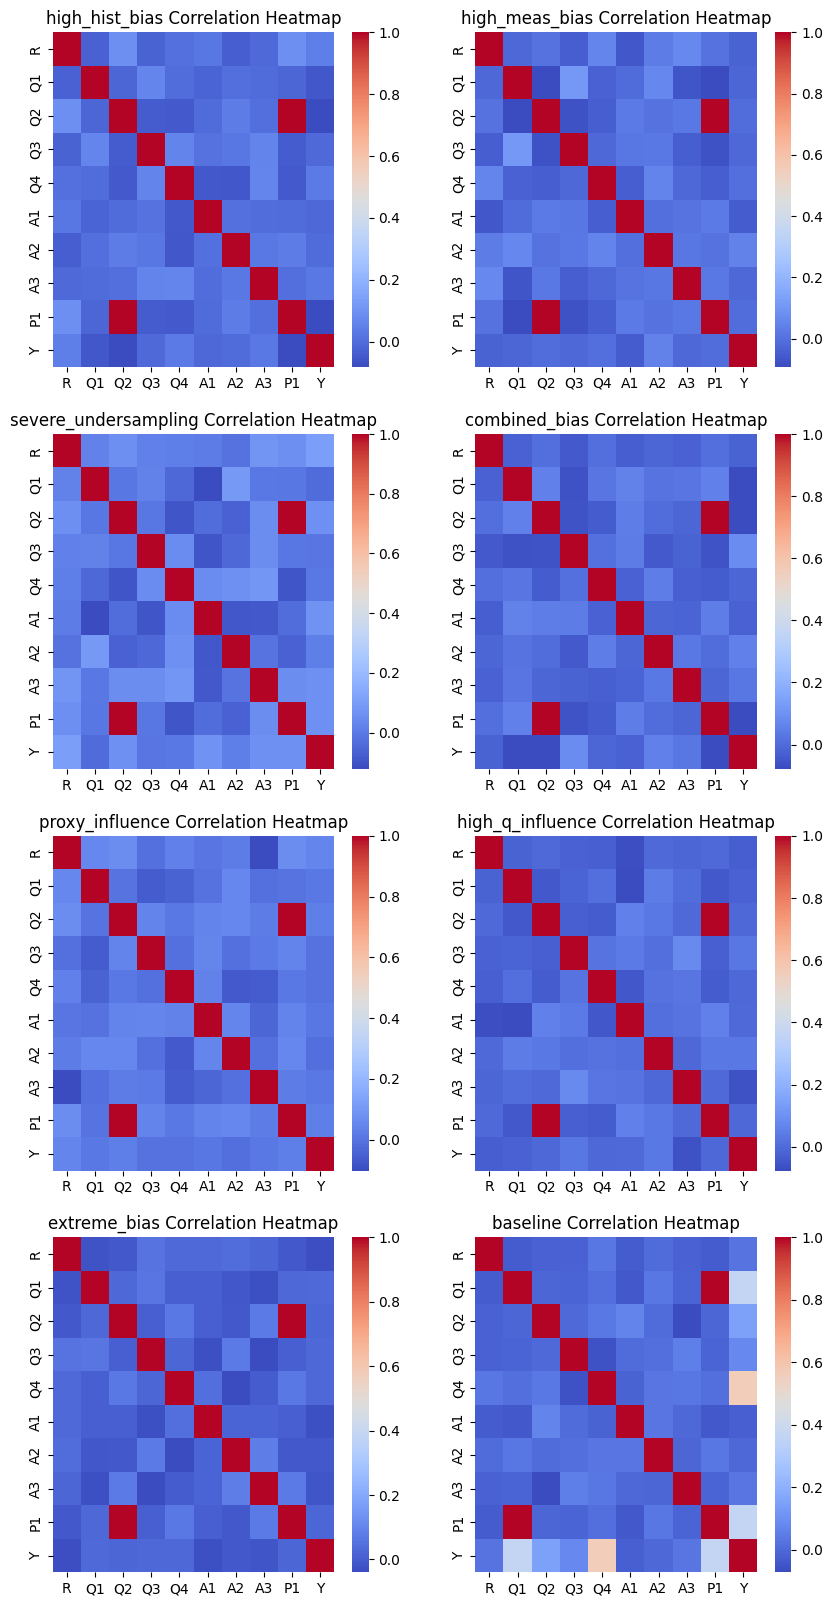

In [35]:
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
axs = axs.flatten()

for i, setting_name in enumerate(bias_analysis_results.keys()):
    corr = bias_analysis_results[setting_name]['correlation_heatmap']

    sns.heatmap(corr, ax=axs[i], cmap='coolwarm')
    axs[i].set_title(f'{setting_name} Correlation Heatmap')

plt.show()

In [36]:
# fig, axs = plt.subplots(4, 2, figsize=(10, 20))
# axs = axs.flatten()

# for i, setting_name in enumerate(bias_analysis_results.keys()):
#     cm = bias_analysis_results[setting_name]['confusion_matrix']

#     cmd = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
#     cmd.plot(ax=axs[i])
#     axs[i].set_title(f'{setting_name} Confusion Matrix')

# plt.show()


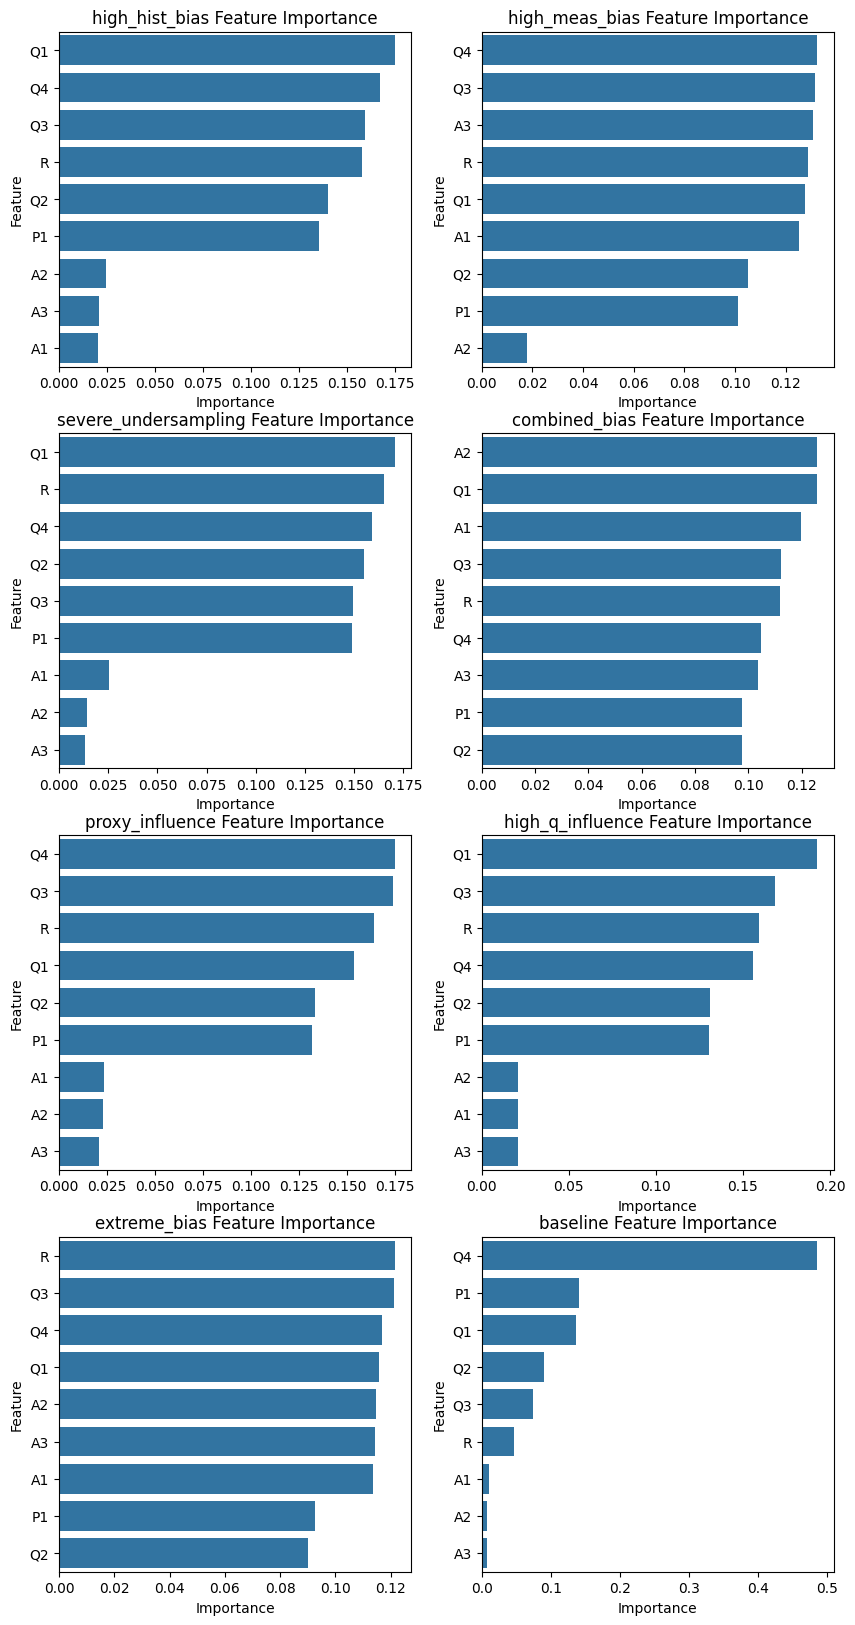

In [37]:
fig, axs = plt.subplots(4, 2, figsize=(10, 20))
axs = axs.flatten()

for i, setting_name in enumerate(bias_analysis_results.keys()):
    feature_importance_df = bias_analysis_results[setting_name]['feature_importance']

    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, ax=axs[i])
    axs[i].set_title(f'{setting_name} Feature Importance')

plt.show()

## Fairness Metrics

Explicação Demographic Parity

In [38]:
def demographic_parity(y_pred, protected_values):
    group_parity = {}
    for group in np.unique(protected_values):
        group_idx = protected_values == group
        group_parity[group] = np.mean(y_pred[group_idx])
    return group_parity

Explicação Equal Opportunity

In [39]:
def equal_opportunity(y_true, y_pred, protected_values):
    tpr = {}
    for group in np.unique(protected_values):
        group_idx = protected_values == group
        tpr[group] = np.mean(y_pred[group_idx] == y_true[group_idx])
    return tpr

Explicação Equalized Odds

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def equalized_odds(y_true, y_pred, protected_values):
    eqo = {}
    for group in np.unique(protected_values):
        group_idx = protected_values == group
        group_y_true = y_true[group_idx]
        group_y_pred = y_pred[group_idx]
        mae = mean_absolute_error(group_y_true, group_y_pred)
        mse = mean_squared_error(group_y_true, group_y_pred)
        eqo[group] = {'MAE': mae, 'MSE': mse}
    return eqo

In [41]:
protected_attributes = ['A1', 'A2', 'A3']

In [42]:
fairness_results = {}

for setting_name in datasets.keys():
    y_test = datasets[setting_name]['y_test']
    x_test = datasets[setting_name]['X_test']
    y_train = datasets[setting_name]['y_train']
    x_train = datasets[setting_name]['X_train']

    clf = RandomForestClassifier(random_state=42)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    fairness_results[setting_name] = {}

    for protected_attribute in protected_attributes:
        if protected_attribute in x_test.columns:
            protected_values = x_test[protected_attribute]

            # Compute fairness metrics
            dp = demographic_parity(y_pred, protected_values)
            eo = equal_opportunity(y_test.values, y_pred, protected_values)
            eq = equalized_odds(y_test.values, y_pred, protected_values)

            # Initialize the structure for the protected attribute
            fairness_results[setting_name][protected_attribute] = {
                'DP': dp,
                'EO': eo,
                'EQ': eq,
                'Groups': {}
            }

            # Calculate group fairness metrics
            for group in np.unique(protected_values):
                group_idx = protected_values == group
                group_y_true = y_test[group_idx]
                group_y_pred = y_pred[group_idx]

                fairness_results[setting_name][protected_attribute]['Groups'][group] = {
                    'Accuracy': accuracy_score(group_y_true, group_y_pred),
                    'MAE': mean_absolute_error(group_y_true, group_y_pred),
                    'MSE': mean_squared_error(group_y_true, group_y_pred)
                }

print(fairness_results)


{'high_hist_bias': {'A1': {'DP': {0: 0.9534883720930233, 1: 0.9367088607594937}, 'EO': {0: 0.7267441860465116, 1: 0.7531645569620253}, 'EQ': {0: {'MAE': 0.27325581395348836, 'MSE': 0.27325581395348836}, 1: {'MAE': 0.2468354430379747, 'MSE': 0.2468354430379747}}, 'Groups': {0: {'Accuracy': 0.7267441860465116, 'MAE': 0.27325581395348836, 'MSE': 0.27325581395348836}, 1: {'Accuracy': 0.7531645569620253, 'MAE': 0.2468354430379747, 'MSE': 0.2468354430379747}}}, 'A2': {'DP': {0: 0.9349112426035503, 1: 0.9565217391304348}, 'EO': {0: 0.7337278106508875, 1: 0.7453416149068323}, 'EQ': {0: {'MAE': 0.26627218934911245, 'MSE': 0.26627218934911245}, 1: {'MAE': 0.2546583850931677, 'MSE': 0.2546583850931677}}, 'Groups': {0: {'Accuracy': 0.7337278106508875, 'MAE': 0.26627218934911245, 'MSE': 0.26627218934911245}, 1: {'Accuracy': 0.7453416149068323, 'MAE': 0.2546583850931677, 'MSE': 0.2546583850931677}}}, 'A3': {'DP': {0: 0.9397590361445783, 1: 0.9512195121951219}, 'EO': {0: 0.7409638554216867, 1: 0.7378

In [43]:
for setting_name in fairness_results.keys():
    for protected_attribute in fairness_results[setting_name].keys():
        print(f'{setting_name} - {protected_attribute}')
        print('Demographic Parity:', fairness_results[setting_name][protected_attribute]['DP'])
        print('Equalized Odds:', fairness_results[setting_name][protected_attribute]['EO'])
        print('Equal Opportunity:', fairness_results[setting_name][protected_attribute]['EQ'])

        print('Group Metrics:')
        for group, metrics in fairness_results[setting_name][protected_attribute]['Groups'].items():
            print(f'  Group {group}:')
            for metric_name, metric_value in metrics.items():
                print(f'    {metric_name}: {metric_value}')


high_hist_bias - A1
Demographic Parity: {0: 0.9534883720930233, 1: 0.9367088607594937}
Equalized Odds: {0: 0.7267441860465116, 1: 0.7531645569620253}
Equal Opportunity: {0: {'MAE': 0.27325581395348836, 'MSE': 0.27325581395348836}, 1: {'MAE': 0.2468354430379747, 'MSE': 0.2468354430379747}}
Group Metrics:
  Group 0:
    Accuracy: 0.7267441860465116
    MAE: 0.27325581395348836
    MSE: 0.27325581395348836
  Group 1:
    Accuracy: 0.7531645569620253
    MAE: 0.2468354430379747
    MSE: 0.2468354430379747
high_hist_bias - A2
Demographic Parity: {0: 0.9349112426035503, 1: 0.9565217391304348}
Equalized Odds: {0: 0.7337278106508875, 1: 0.7453416149068323}
Equal Opportunity: {0: {'MAE': 0.26627218934911245, 'MSE': 0.26627218934911245}, 1: {'MAE': 0.2546583850931677, 'MSE': 0.2546583850931677}}
Group Metrics:
  Group 0:
    Accuracy: 0.7337278106508875
    MAE: 0.26627218934911245
    MSE: 0.26627218934911245
  Group 1:
    Accuracy: 0.7453416149068323
    MAE: 0.2546583850931677
    MSE: 0.254

In [44]:
from aequitas import Audit

audit_results = {}

for setting_name in datasets.keys():
    y_test = datasets[setting_name]['y_test']
    y_test_real = datasets[setting_name]['y_real']

    x_test = datasets[setting_name]['X_test']
    y_train = datasets[setting_name]['y_train']
    x_train = datasets[setting_name]['X_train']

    x_train['A1'] = x_train['A1'].map({1: 'A', 0: 'B'})
    x_train['A2'] = x_train['A2'].map({1: 'A', 0: 'B'})
    x_train['A3'] = x_train['A3'].map({1: 'A', 0: 'B'})
    x_test['A1'] = x_test['A1'].map({1: 'A', 0: 'B'})
    x_test['A2'] = x_test['A2'].map({1: 'A', 0: 'B'})
    x_test['A3'] = x_test['A3'].map({1: 'A', 0: 'B'})

    x_train['A1'] = x_train['A1'].astype('object')
    x_train['A2'] = x_train['A2'].astype('object')
    x_train['A3'] = x_train['A3'].astype('object')
    x_test['A1'] = x_test['A1'].astype('object')
    x_test['A2'] = x_test['A2'].astype('object')
    x_test['A3'] = x_test['A3'].astype('object')

    df = pd.concat([x_test, y_test], axis=1)

    df['y_real'] = y_test_real

    print(df.columns)

    # drop rows with missing values
    df = df.dropna()

    df['Y'] = df['Y'].astype('int')
    df['y_real'] = df['y_real'].astype('int')

    audit = Audit(df, score_column='Y', sensitive_attribute_column=['A1','A2','A3'], label_column='y_real', threshold=1)

    audit_results[setting_name] = audit

Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'y_real'], dtype='object')
Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'y_real'], dtype='object')
Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'y_real'], dtype='object')


Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'y_real'], dtype='object')
Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'y_real'], dtype='object')
Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'y_real'], dtype='object')
Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'y_real'], dtype='object')
Index(['R', 'Q1', 'Q2', 'Q3', 'Q4', 'A1', 'A2', 'A3', 'P1', 'Y', 'y_real'], dtype='object')


In [45]:
audit_baseline = audit_results['baseline']
audit_high_hist_bias = audit_results['high_hist_bias']
audit_high_meas_bias = audit_results['high_meas_bias']
audit_severe_undersampling = audit_results['severe_undersampling']
audit_combined_bias = audit_results['combined_bias']
audit_proxy_influence = audit_results['proxy_influence']
audit_high_q_influence = audit_results['high_q_influence']
audit_extreme_bias = audit_results['extreme_bias']

In [46]:
audit_baseline.summary_plot(["tpr", "fpr", "pprev"])

alt.VConcatChart(...)

In [47]:
audit_high_hist_bias.summary_plot(["tpr", "fpr", "pprev"])

alt.VConcatChart(...)

In [48]:
audit_high_meas_bias.summary_plot(["tpr", "fpr", "pprev"])

ValueError: max() arg is an empty sequence

In [49]:
audit_severe_undersampling.summary_plot(["tpr", "fpr", "pprev"])

alt.VConcatChart(...)

In [50]:
audit_combined_bias.summary_plot(["tpr", "fpr", "pprev"])

ValueError: max() arg is an empty sequence

In [51]:
audit_high_q_influence.summary_plot(["tpr", "fpr", "pprev"])

alt.VConcatChart(...)

In [52]:
audit_extreme_bias.summary_plot(["tpr", "fpr", "pprev"])

ValueError: max() arg is an empty sequence

## References

**Baumann, Joachim**, **Castelnovo, Alessandro**, **Crupi, Riccardo**, **Inverardi, Nicole**, and **Regoli, Daniele**. 2023. **Bias on Demand: A Modelling Framework That Generates Synthetic Data With Bias**. *In Proceedings of the 2023 ACM Conference on Fairness, Accountability, and Transparency*. [https://doi.org/10.1145/3593013.3594058](https://doi.org/10.1145/3593013.3594058).
